In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, Concatenate, Conv2DTranspose, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import Model,regularizers
import tensorflow as tf
from PIL import Image, ImageFilter,GifImagePlugin

In [7]:
Img_width = 256
Img_height = 256

batch_size = 16
epochs = 100


In [37]:
def load_data(is_train = True):
    path = os.path.join('/Users','egormatolygin','Data','P3M-10k','train_list.txt') 
    file = open(path)
    imageNames = file.read().split()
    train = []
    for name in imageNames:
        imagePath = os.path.join('/Users','egormatolygin','Data','P3M-10k','train','blurred_image',name+'.jpg')
        labelPath = os.path.join('/Users','egormatolygin','Data','P3M-10k','train','mask',name+'.png')
        train.append([imagePath,labelPath])
    file.close()
    val = []
    imageNames = [im.removesuffix('.jpg') for im in os.listdir('/Users/egormatolygin/Data/P3M-10k/validation/P3M-500-NP/original_image')]
    for name in imageNames:
        imagePath = os.path.join('/Users','egormatolygin','Data','P3M-10k','validation','P3M-500-NP','original_image',name+'.jpg')
        labelPath = os.path.join('/Users','egormatolygin','Data','P3M-10k','validation','P3M-500-NP','mask',name+'.png')
        val.append([imagePath,labelPath])
        
    return train,val

In [38]:
train,val = load_data()

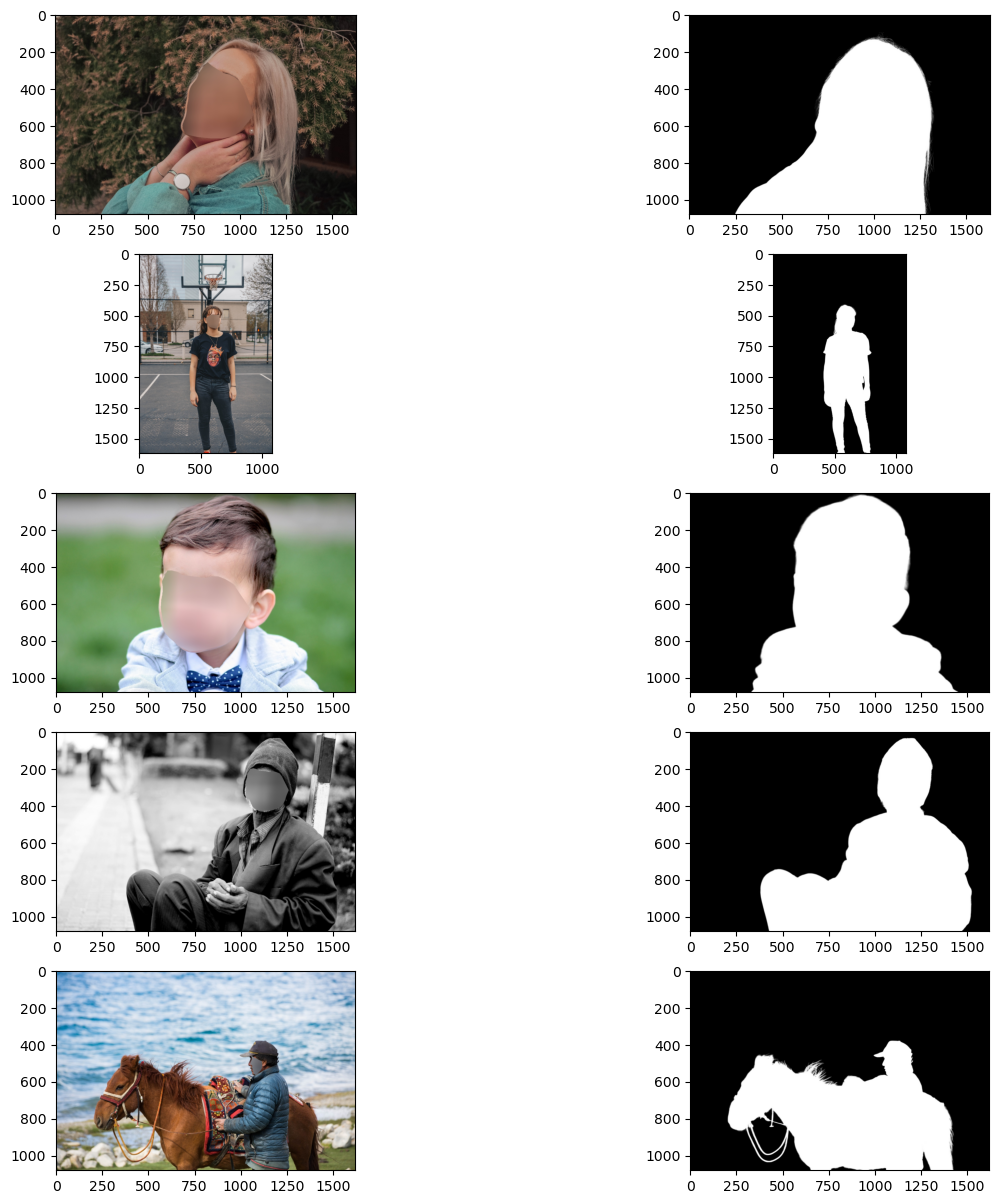

In [41]:
plt.figure(figsize=(15,15))
idx = 0
img = 0
mask = 0
for image in train[:5]:
    plt.subplot(5,2,idx+1)
    plt.imshow(Image.open(image[0]))
    plt.subplot(5,2,idx+2)
    plt.imshow(Image.open(image[1]))
    idx+=2
    

In [42]:
def prep_image_and_mask(train,val):
    Images_train = []
    Masks_train = []
    Images_val = []
    Masks_val = []
    
    for pair in train:
        Img = Image.open(pair[0])
        Img = Img.resize((Img_height,Img_width),resample = Image.BILINEAR)
        Images_train.append(np.array(Img))
        Mask = Image.open(pair[1])
        Mask = Mask.resize((Img_height,Img_width),resample = Image.BILINEAR)
        Mask = np.array(Mask)[:,:,0]
        Mask = Mask/255
        Masks_train.append(Mask.reshape(Img_width,Img_height,1))

    for pair in val:
        Img = Image.open(pair[0])
        Img = Img.resize((Img_height,Img_width),resample = Image.BILINEAR)
        Images_val.append(np.array(Img))
        Mask = Image.open(pair[1])
        Mask = Mask.resize((Img_height,Img_width),resample = Image.BILINEAR)
        Mask = np.array(Mask)[:,:,0]
        Mask = Mask/255
        Masks_val.append(Mask.reshape(Img_width,Img_height,1))

    return np.array(Images_train), np.array(Masks_train), np.array(Images_val),np.array(Masks_val)

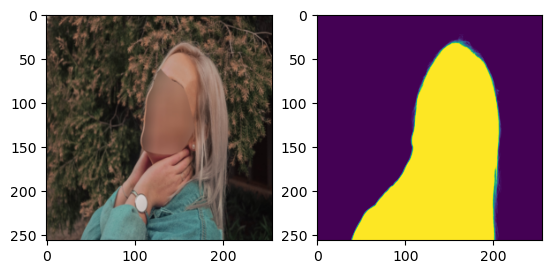

In [43]:
Images_train, Masks_train, Images_val, Masks_val = prep_image_and_mask(train,val)
plt.subplot(1,2,1)
plt.imshow(Images_train[0])
plt.subplot(1,2,2)
plt.imshow(Masks_train[0])

In [44]:
print(Images_train.shape,Masks_train.shape,Images_val.shape,Masks_val.shape)

(9421, 256, 256, 3) (9421, 256, 256, 1) (500, 256, 256, 3) (500, 256, 256, 1)


In [2]:
def get_model():
    x = Input(shape=(256,256,3))
    
    conv1 = Conv2D(kernel_size=3,filters=64, strides=1, padding='same',input_shape = (256,256,3),
                   kernel_regularizer=regularizers.l2(0.0001))(x)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(kernel_size=3,filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv1)
    #conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool1 = MaxPool2D(pool_size=(2,2))(conv2)
    
   
    conv3 = Conv2D(kernel_size=3,filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(pool1)
    #conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv4 = Conv2D(kernel_size=3,filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv3)
    #conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool2 = MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5 = Conv2D(kernel_size=3,filters=128,strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(pool2)
    #conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv6 = Conv2D(kernel_size=3, filters=128, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv5)
    #conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv7 = Conv2D(kernel_size=3, filters=128, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv6)
    #conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    pool3 = MaxPool2D(pool_size=(2,2))(conv7)
    
   
    conv8 = Conv2D(kernel_size=3, filters=256, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(pool3)
    #conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv9 = Conv2D(kernel_size=3, filters=256, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv8)
    #conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    upconv1 = Conv2DTranspose(kernel_size=3,filters=128, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv9)
    #upconv1 = BatchNormalization()(upconv1)
    upconv1 = Activation('relu')(upconv1)
    
    skip1 = Concatenate(axis = 3)([upconv1,conv7])
    conv10 = Conv2D(kernel_size=3, filters=128, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(skip1)
    #conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    conv11 = Conv2D(kernel_size=3, filters=128, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv10)
    #conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    conv12 = Conv2D(kernel_size=3, filters=128, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(conv11)
    #conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)
    upconv2 = Conv2DTranspose(kernel_size=3,filters=64, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv12)
    #upconv2 = BatchNormalization()(upconv2)
    upconv2 = Activation('relu')(upconv2)
    

    skip2 = Concatenate(axis = 3)([upconv2,conv4])
    conv13 = Conv2D(kernel_size=3, filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(upconv2)
    #conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    conv14 = Conv2D(kernel_size=3, filters=64, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(conv13)
    #conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)
    upconv3 = Conv2DTranspose(kernel_size=3,filters=64, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv14)
    #upconv3 = BatchNormalization()(upconv3)
    upconv3 = Activation('relu')(upconv3)

    skip3 = Concatenate(axis = 3)([upconv3,conv2])
    conv15 = Conv2D(kernel_size=3, filters=64, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(upconv3)
    #conv15 = BatchNormalization()(conv15)
    conv15 = Activation('relu')(conv15)
    output = Conv2D(kernel_size=3, filters=1, strides=1, padding='same', activation='sigmoid', 
                    kernel_regularizer=regularizers.l2(0.0001))(conv15)

    model = Model(inputs = x, outputs = output)
    model.summary()
    optimizer = Adam(learning_rate=0.01)
    model.compile(loss ='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

def get_model1():
    x = Input(shape=(256,256,3))
    
    conv1 = Conv2D(kernel_size=3,filters=64, strides=1, padding='same',input_shape = (256,256,3),
                  kernel_regularizer=regularizers.l2(0.0001))(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(kernel_size=3,filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool1 = MaxPool2D(pool_size=(2,2))(conv2)
    
   
    conv3 = Conv2D(kernel_size=3,filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv4 = Conv2D(kernel_size=3,filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool2 = MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5 = Conv2D(kernel_size=3,filters=128,strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv6 = Conv2D(kernel_size=3, filters=128, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    
   
    conv8 = Conv2D(kernel_size=3, filters=256, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(pool3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv9 = Conv2D(kernel_size=3, filters=256, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv8)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    upconv1 = Conv2DTranspose(kernel_size=3,filters=128, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv9)
    upconv1 = BatchNormalization()(upconv1)
    upconv1 = Activation('relu')(upconv1)
    
    skip1 = Concatenate(axis = 3)([upconv1,conv6])
    conv10 = Conv2D(kernel_size=3, filters=128, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(skip1)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    conv11 = Conv2D(kernel_size=3, filters=128, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    upconv2 = Conv2DTranspose(kernel_size=3,filters=64, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv11)
    upconv2 = BatchNormalization()(upconv2)
    upconv2 = Activation('relu')(upconv2)
    

    skip2 = Concatenate(axis = 3)([upconv2,conv4])
    conv13 = Conv2D(kernel_size=3, filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(skip2)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    conv14 = Conv2D(kernel_size=3, filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)
    upconv3 = Conv2DTranspose(kernel_size=3,filters=64, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv14)
    upconv3 = BatchNormalization()(upconv3)
    upconv3 = Activation('relu')(upconv3)

    skip3 = Concatenate(axis = 3)([upconv3,conv2])
    conv15 = Conv2D(kernel_size=3, filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(skip3)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation('relu')(conv15)
    conv16 = Conv2D(kernel_size=3, filters=64, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(conv15)
    conv16 = BatchNormalization()(conv16)
    conv16 = Activation('relu')(conv16)
    output = Conv2D(kernel_size=3, filters=1, strides=1, padding='same', activation='sigmoid',kernel_regularizer=regularizers.l2(0.0001))(conv15)

    model = Model(inputs = x, outputs = output)
    model.summary()
    optimizer = Adam(learning_rate=0.0001,weight_decay=0.000001)
    model.compile(loss ='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model



2023-10-13 20:43:06.800649: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-13 20:43:06.800901: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-13 20:43:06.801310: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-13 20:43:06.801372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-13 20:43:06.801405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

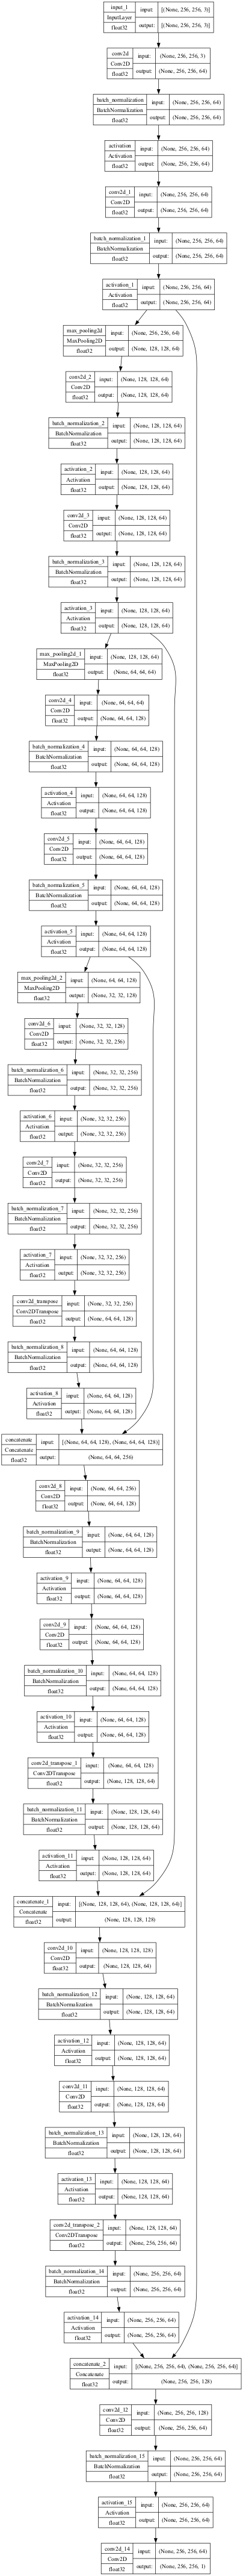

<Figure size 200x200 with 0 Axes>

In [10]:
plt.figure(figsize=(2,2))
model =  get_model1()
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,dpi = 50,rankdir ='TL')

In [11]:
def learning_rate_scheduler(epoch, lr): 
        if (epoch + 1) % 33 == 0:
           lr = lr / 10
        return lr
lrs = LearningRateScheduler(learning_rate_scheduler, verbose=1)
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

In [12]:
generator = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)
generator.fit(Images_train)

history = model.fit(generator.flow(Images_train,Masks_train,batch_size = batch_size), callbacks=[checkpointer], 
    steps_per_epoch=Images_train.shape[0] // batch_size, epochs=epochs, verbose=2, validation_data=(Images_val, Masks_val))

Epoch 1/100


2023-10-13 20:43:37.414757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-13 21:05:33.334846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.55337, saving model to model.weights.best.hdf5


/Users/egormatolygin/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


588/588 - 1351s - loss: 0.6645 - accuracy: 0.7277 - val_loss: 0.5534 - val_accuracy: 0.7997 - 1351s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss improved from 0.55337 to 0.52019, saving model to model.weights.best.hdf5
588/588 - 1786s - loss: 0.5988 - accuracy: 0.7647 - val_loss: 0.5202 - val_accuracy: 0.8091 - 1786s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss improved from 0.52019 to 0.48102, saving model to model.weights.best.hdf5
588/588 - 1459s - loss: 0.5712 - accuracy: 0.7734 - val_loss: 0.4810 - val_accuracy: 0.8287 - 1459s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.48102
588/588 - 1656s - loss: 0.5519 - accuracy: 0.7766 - val_loss: 0.4877 - val_accuracy: 0.8085 - 1656s/epoch - 3s/step
Epoch 5/100

Epoch 5: val_loss improved from 0.48102 to 0.45374, saving model to model.weights.best.hdf5
588/588 - 1632s - loss: 0.5372 - accuracy: 0.7793 - val_loss: 0.4537 - val_accuracy: 0.8273 - 1632s/epoch - 3s/step
Epoch 6/100

Epoch 6: val_loss improved from 

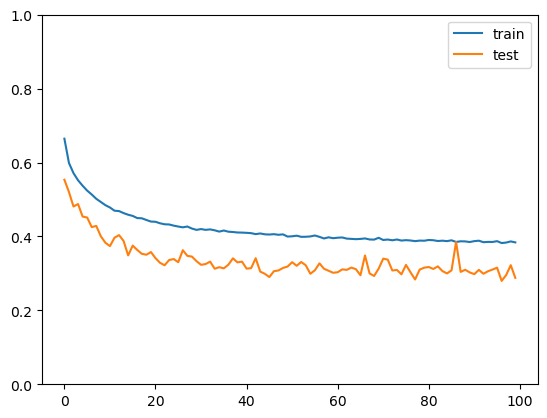

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim((0,1))
plt.legend()
plt.show()

In [4]:
model = get_model1()
model.load_weights("/Users/egormatolygin/Desktop/Полка/Pet_projects/back_blure/weights/model1.0.weights.best.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_17 (Ba  (None, 256, 256, 64)         256       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_17

(1, 256, 256, 3)
1/1 [==============================] - 0s 23ms/step


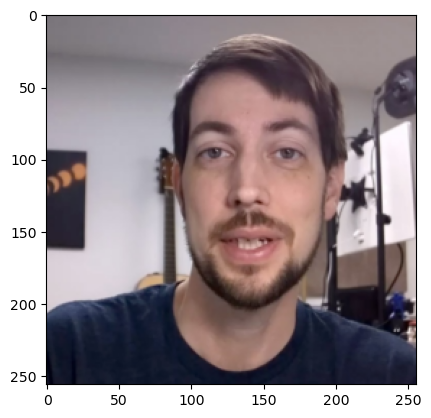

In [20]:
img = Image.open('/Users/egormatolygin/Desktop/Полка/Pet_projects/back_blure/images/jeff-dell-xps-framegrab-pi-webcam.jpg')
img = img.resize((Img_height,Img_width),resample = Image.BILINEAR)
img = np.array(img).reshape(1,256,256,3)
plt.imshow(img[0])
print(img.shape)

mask = model.predict(img)[0]

In [21]:
def blure(img,mask):
    img = Image.fromarray(img[0])
    out = []
    blured = img.filter(ImageFilter.GaussianBlur(10))
    img = np.array(img)
    blured = np.array(blured)
    for i in range(256):
        for j in range(256):
            out.append((int(img[i][j][0]*mask[i][j]+blured[i][j][0]*(1-mask[i][j])),
                        int(img[i][j][1]*mask[i][j]+blured[i][j][1]*(1-mask[i][j])),
                        int(img[i][j][2]*mask[i][j]+blured[i][j][2]*(1-mask[i][j]))))
    out = np.array(out)
    out = out.reshape(256,256,3)
    return out

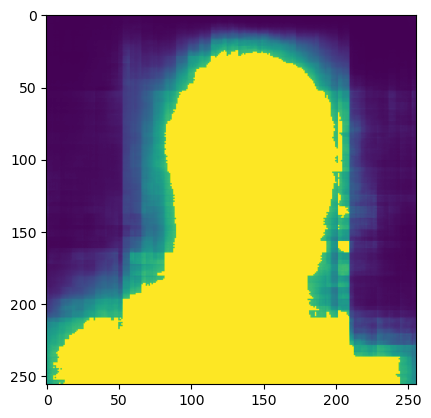

In [22]:
mask[mask>0.7] = 1
plt.imshow(mask)

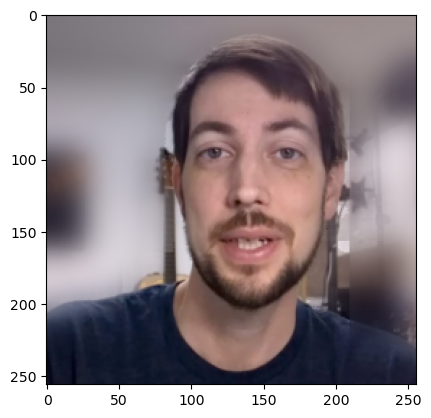

In [23]:

plt.imshow(blure(img,mask))

In [33]:
def add_background(img,mask,background):
    img = img[0]
    background = background[0]
    out = []
    for i in range(256):
        for j in range(256):
            out.append((int(img[i][j][0]*mask[i][j]+background[i][j][0]*(1-mask[i][j])),
                        int(img[i][j][1]*mask[i][j]+background[i][j][1]*(1-mask[i][j])),
                        int(img[i][j][2]*mask[i][j]+background[i][j][2]*(1-mask[i][j]))))
    out = np.array(out)
    out = out.reshape(256,256,3)
    return out

(1, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step


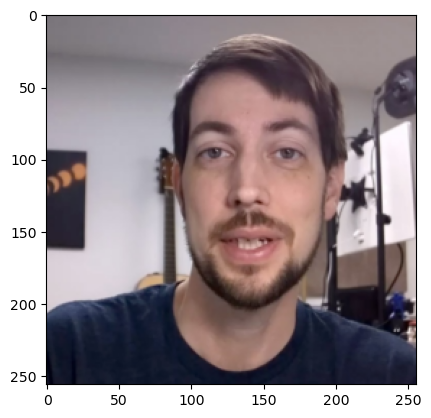

In [34]:
img = Image.open('/Users/egormatolygin/Desktop/Полка/Pet_projects/back_blure/images/jeff-dell-xps-framegrab-pi-webcam.jpg')
img = img.resize((Img_height,Img_width),resample = Image.BILINEAR)
img = np.array(img).reshape(1,256,256,3)
plt.imshow(img[0])
print(img.shape)
mask = model.predict(img)[0]

back = Image.open('/Users/egormatolygin/Desktop/Полка/Pet_projects/back_blure/images/champagne-beach-espiritu-santo-island-vanuatu-royalty-free-image-1655672510.jpg')
back = back.resize((Img_height,Img_width),resample = Image.BILINEAR)
back = np.array(back).reshape(1,256,256,3)

array([0.01651757], dtype=float32)

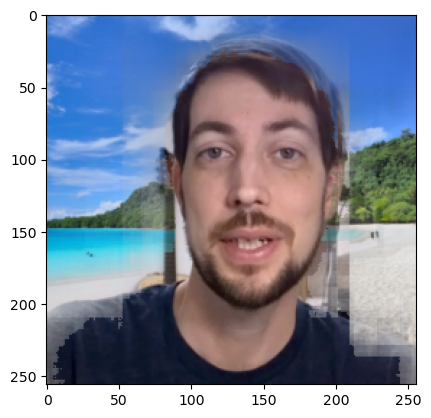

In [35]:
mask[mask>0.7] = 1
plt.imshow(add_background(img,mask,back))
mask[i][j]

(1, 256, 256, 3)
1/1 [==============================] - 0s 22ms/step


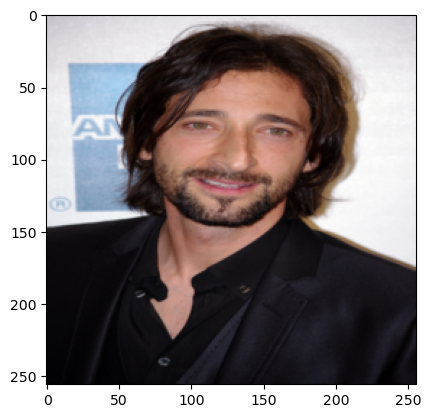

In [45]:
img = Images_val[37]
img = np.array(img).reshape(1,256,256,3)
plt.imshow(img[0])
print(img.shape)
mask = model.predict(img)[0]

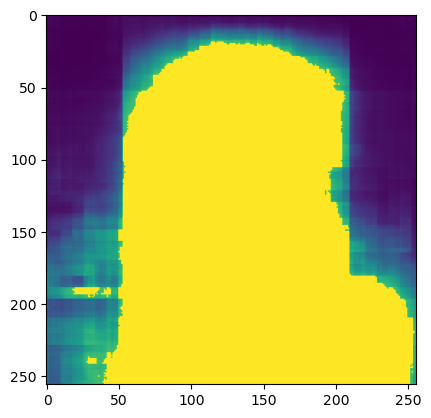

In [46]:
mask[mask>0.7] = 1
plt.imshow(mask)

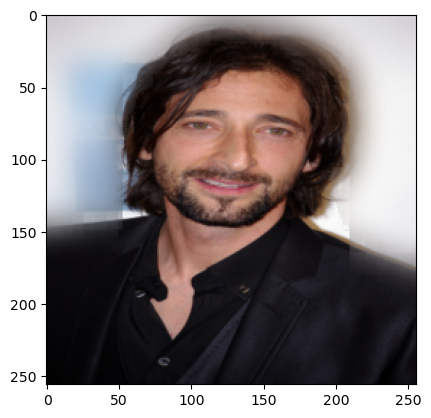

In [47]:
plt.imshow(blure(img,mask))